# Parse Optode


In [40]:
## Install the package if needed:
#install.packages('geosphere', repos='http://cran.us.r-project.org')

## Load the relevent packages
library(ncdf4)  # For reading in the NCEP wind fields
library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
#library(rNOMADS)  # For reading grib2 data files (NOMADS data for instance)
#library(rGDAL)  #
library(RColorBrewer)
library(compiler)  # required for JIT (below)
library(lattice)
library(geosphere)
library(data.table)

## Enable compilation (speed gain?)
enableJIT(3)


## Moving Average function (for smoothing)
ma <- function(x, n=5){
    as.numeric(filter(x,rep(1/n,n), sides=2))
}


## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='GMT') {
    as.POSIXct(as.Date(x, origin="1899-12-30", tz=tz))
}

conv_roms_time = function(x, tz='UTC') {
    as.POSIXct(x, origin="1900-01-01")
}

get.qual.pal = function(n=100, pal='Accent') {
    colorRampPalette(brewer.pal(8, pal))(n)
}

get.seq.pal = function(n=100, pal='YlOrRd') {
    colorRampPalette(rev(brewer.pal(9, pal)))(n)
}

get.div.pal = function(n=100, pal='Spectral') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

make.div.pal = function(x=100, n, pal='Spectral') {
    get.div.pal(n, pal=pal)[as.numeric(cut(x, breaks = n))]
}

[1] 3

In [2]:
input.dir = 'Raw Data/O2-optode MIMS/'

file.list = list.files(input.dir)
file.list = file.list[!grepl('.xlsx', file.list)]
file.list = file.list[grepl('.txt', file.list)]
length(file.list)

[1] 44

In [135]:
process.file = function(input.dir, file) {
    data = data.frame(Date = '', Time = '', Rel.Time = '',
                      Oxy.ch1 = 0, Oxy.ch2 = 0, Oxy.ch3 = 0, Oxy.ch4 = 0,
                      Temp.ch1 = 0, Temp.ch2 = 0, Temp.ch3 = 0, Temp.ch4 = 0, Pressure = 0, stringsAsFactors = FALSE)
    
    temp = fread(paste0(input.dir, file), skip = 20, sep = '\t')[,c(1:3, 5:13)]
    colnames(temp) = colnames(data)
    data = rbind(data, temp)
    data = data[-1,]
    data = data[,-3]
    data = as.data.frame(data)
    data$Time = add.time(data$Date, data$Time)
    data
}

add.time = function(dates, times) {
    ans = as.POSIXct('5/16/2017 14:07:10', format = '%m/%d/%Y %H:%M:%S', tz = 'GMT')
    if (grepl('2017', dates[2])) {
        format = '%m/%d/%Y %H:%M:%S'
    } else {
        format = '%m/%d/%y %H:%M:%S'
    }
    for (i in 1:length(dates)) {
        ans = c(ans, as.POSIXct(paste(dates[i], times[i]), format = format, tz = 'GMT'))
    }
    ans = ans[-1]
    ans
}

avg.data = function(data, N = 120, time.as.char = FALSE) {
    i = 1
    
    for (j in 3:ncol(data)) {
        data[,j] = as.numeric(data[,j])
    }
    
    while (i < nrow(data)) {
        dt = as.numeric(difftime(data$Time, data$Time[i], unit = 'secs'))
        l = which(dt >= 0 & dt < N)
        
        ## Dataset to be averaged.
        temp = data[l,]
        
        ## Take average of each field (couldn't find a more elegant solution)
        temp$Oxy.ch1 = mean(temp$Oxy.ch1[temp$Oxy.ch1.flag == 1], na.rm = TRUE)
        temp$Oxy.ch2 = mean(temp$Oxy.ch2[temp$Oxy.ch2.flag == 1], na.rm = TRUE)
        temp$Oxy.ch3 = mean(temp$Oxy.ch3[temp$Oxy.ch3.flag == 1], na.rm = TRUE)
        temp$Oxy.ch4 = mean(temp$Oxy.ch4[temp$Oxy.ch4.flag == 1], na.rm = TRUE)
        
        temp$Temp.ch1 = mean(temp$Temp.ch1[temp$Temp.ch1.flag == 1], na.rm = TRUE)
        temp$Temp.ch2 = mean(temp$Temp.ch2[temp$Temp.ch2.flag == 1], na.rm = TRUE)
        temp$Temp.ch3 = mean(temp$Temp.ch3[temp$Temp.ch3.flag == 1], na.rm = TRUE)
        temp$Temp.ch4 = mean(temp$Temp.ch4[temp$Temp.ch4.flag == 1], na.rm = TRUE)
        
        temp$Pressure = mean(temp$Pressure[temp$Pressure.flag == 1], na.rm = TRUE)

        ## Save average value
        data[i,] = temp[1,]
        
        if (length(l) > 1) {
            l = l[l != i]
            if (length(l) > 0) {
                data = data[-l,]
            }
        }
        i = i + 1
    }
    if (time.as.char) {
        data$Time = as.character(data$Time, tz = 'GMT')
    }
    data
}

filter.outliers = function(x, n = 30, tol = 3, algo = 'median') {
    ## Assume all points are outliers (deals with NAs this way)
    res = rep(2, length(x)) # invalid
    
    ## Determine smoothing model and get tollerance
    if (algo == 'mean')
        model = ma(x, n)
    if (algo == 'median')
        model = runmed(x, n+1)
    
    ## Apply model
    l = which((x - model)^2 < tol^2)
    res[l] = 1 ## Good data
    res
}

In [112]:
data = process.file(input.dir, file.list[10])
str(data)

'data.frame':	53687 obs. of  12 variables:
 $ Date    : chr  "6/5/2017" "6/5/2017" "6/5/2017" "6/5/2017" ...
 $ Time    : POSIXct, format: "2017-06-04 22:57:21" "2017-06-04 22:57:22" ...
 $ Rel.Time: chr  "0" "1.4" "2.5" "3.77" ...
 $ Oxy.ch1 : num  101 101 101 101 101 ...
 $ Oxy.ch2 : num  99.2 99.3 99.3 99.3 99.3 ...
 $ Oxy.ch3 : num  99.9 100.1 100.2 100.2 100.2 ...
 $ Oxy.ch4 : num  98.5 98.5 98.4 98.4 98.4 ...
 $ Temp.ch1: num  13.8 13.8 13.8 13.8 13.8 ...
 $ Temp.ch2: num  13.8 13.8 13.8 13.8 13.8 ...
 $ Temp.ch3: num  13.8 13.8 13.8 13.8 13.8 ...
 $ Temp.ch4: num  13.8 13.8 13.8 13.8 13.8 ...
 $ Pressure: num  1014 1014 1014 1014 1014 ...


In [134]:
add.filter.flags = function(data) {
    data$Oxy.ch1.flag = filter.outliers(data$Oxy.ch1, n = 60, tol = 3)
    data$Oxy.ch2.flag = filter.outliers(data$Oxy.ch2, n = 60, tol = 3)
    data$Oxy.ch3.flag = filter.outliers(data$Oxy.ch3, n = 60, tol = 3)
    data$Oxy.ch4.flag = filter.outliers(data$Oxy.ch4, n = 60, tol = 3)

    data$Temp.ch1.flag = filter.outliers(data$Temp.ch1, n = 60, tol = 0.2)
    data$Temp.ch2.flag = filter.outliers(data$Temp.ch2, n = 60, tol = 0.2)
    data$Temp.ch3.flag = filter.outliers(data$Temp.ch3, n = 60, tol = 0.2)
    data$Temp.ch4.flag = filter.outliers(data$Temp.ch4, n = 60, tol = 0.2)
    
    data$Pressure.flag = filter.outliers(data$Pressure, n = 60, tol = 0.4)
    
    ## Return
    data
}

In [ ]:
data = add.filter.flags(data)

[1] "Percent removed (Ch1): 1"
[1] "Percent removed (Ch2): 0"


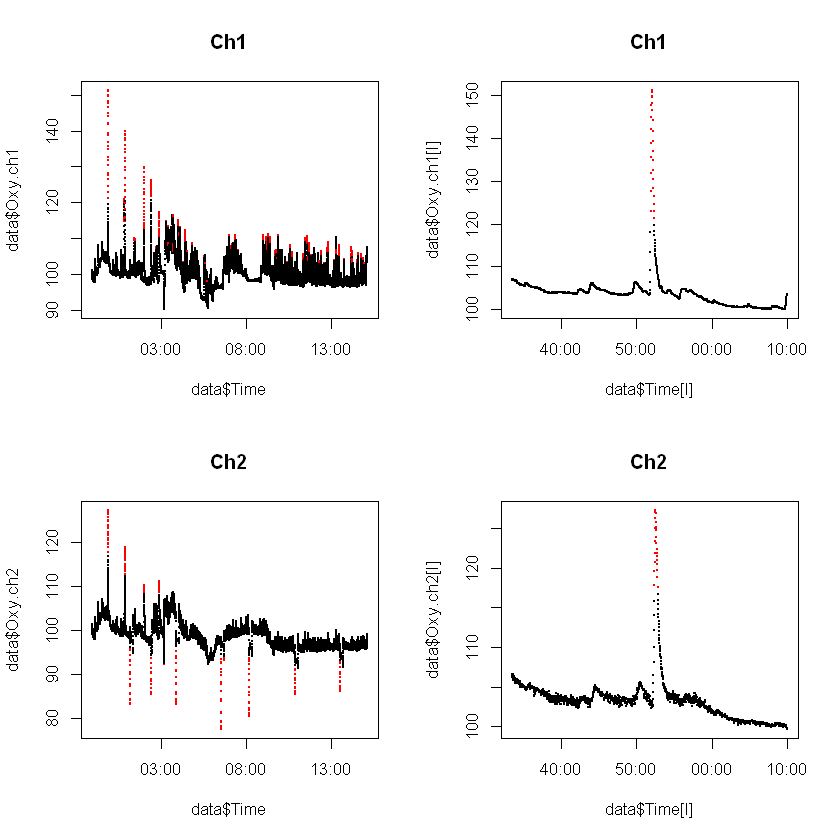

In [118]:
#plot(data$Time, data$Oxy.ch1, type='l')
#lines(data$Time, data$Oxy.ch1.ma, col='red')
par(mfrow=c(2,2))
l = c(2000:4000)

plot(data$Time, data$Oxy.ch1, pch=20, cex=0.2, col = data$Oxy.ch1.flag, main = 'Ch1')
plot(data$Time[l], data$Oxy.ch1[l], pch=20, cex=0.2, col = data$Oxy.ch1.flag[l], main='Ch1')

plot(data$Time, data$Oxy.ch2, pch=20, cex=0.2, col = data$Oxy.ch2.flag, main = 'Ch2')
plot(data$Time[l], data$Oxy.ch2[l], pch=20, cex=0.2, col = data$Oxy.ch2.flag[l], main='Ch2')

## Percentages
ch1 = length(which(data$Oxy.ch1.flag == 2)) / nrow(data)
ch2 = length(which(data$Oxy.ch2.flag == 2)) / nrow(data)

print(paste('Percent removed (Ch1):', floor(ch1*100)))
print(paste('Percent removed (Ch2):', floor(ch2*100)))

[1] "Percent removed (Ch1): 1"
[1] "Percent removed (Ch2): 1"


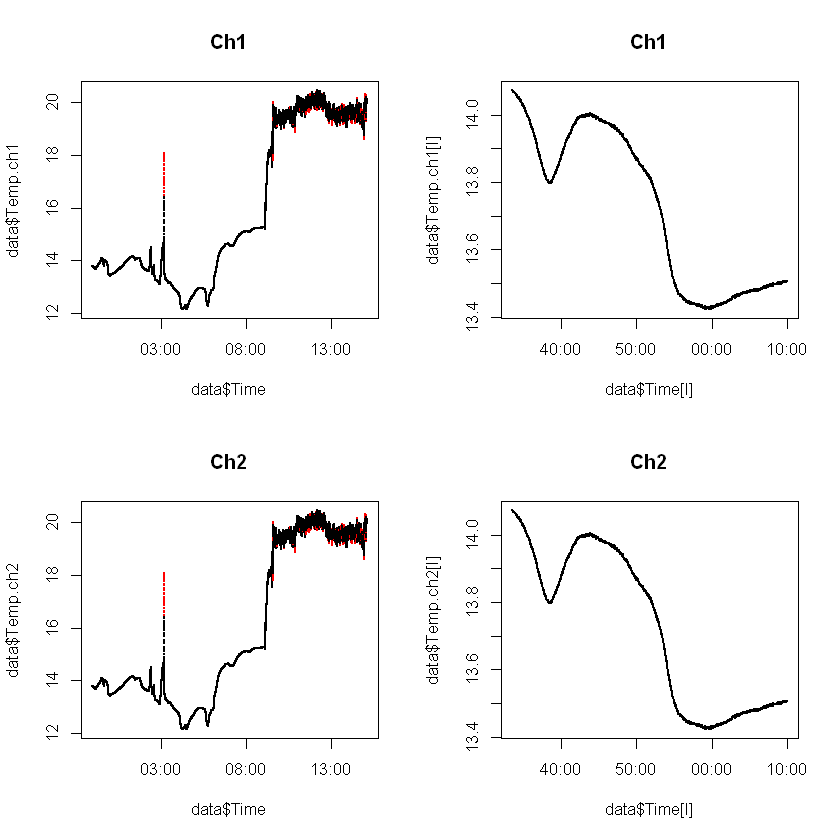

In [126]:
#plot(data$Time, data$Oxy.ch1, type='l')
#lines(data$Time, data$Oxy.ch1.ma, col='red')
par(mfrow=c(2,2))
l = c(2000:4000)

plot(data$Time, data$Temp.ch1, pch=20, cex=0.2, col = data$Temp.ch1.flag, main = 'Ch1')
plot(data$Time[l], data$Temp.ch1[l], pch=20, cex=0.2, col = data$Temp.ch1.flag[l], main='Ch1')

plot(data$Time, data$Temp.ch2, pch=20, cex=0.2, col = data$Temp.ch2.flag, main = 'Ch2')
plot(data$Time[l], data$Temp.ch2[l], pch=20, cex=0.2, col = data$Temp.ch2.flag[l], main='Ch2')

## Percentages
ch1 = length(which(data$Temp.ch1.flag == 2)) / nrow(data)
ch2 = length(which(data$Temp.ch2.flag == 2)) / nrow(data)

print(paste('Percent removed (Ch1):', floor(ch1*100)))
print(paste('Percent removed (Ch2):', floor(ch2*100)))

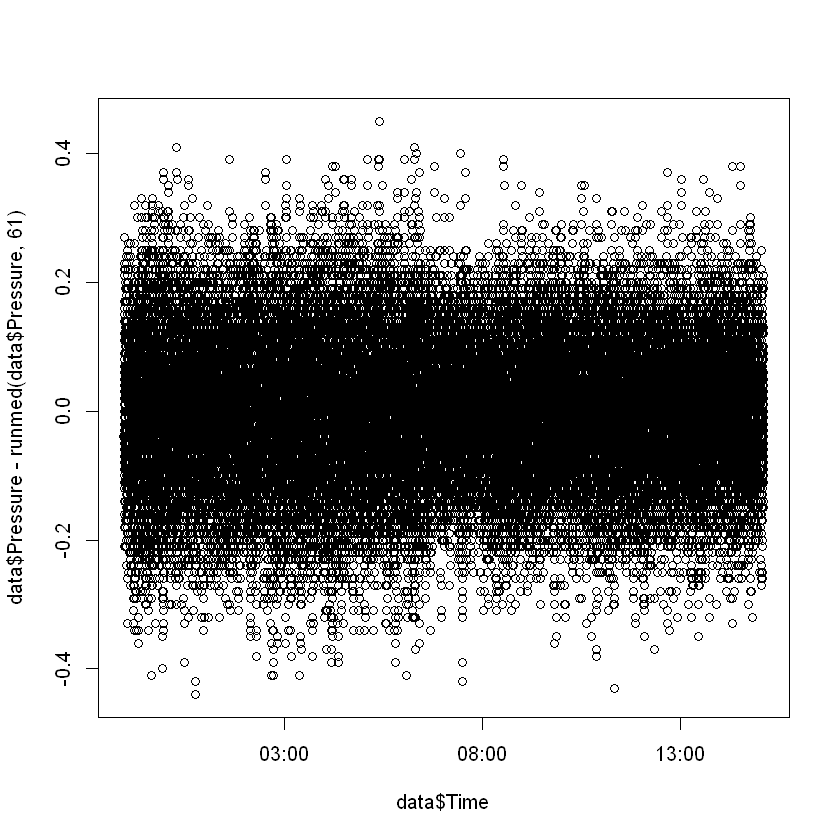

In [133]:
plot(data$Time, data$Pressure - runmed(data$Pressure, 61))

---
# Automate and run

In [136]:
run = function(input.dir, file.list, write.xlsx = FALSE, output.dir = '') {
    data = process.file(input.dir, file.list[10])
    data = add.filter.flags(data)
    data = avg.data(data)
    
    if (write.xlsx) {
        write.xlsx(file = paste0(input.dir, output.dir, file.list[1], '-parsed-avg.xlsx'), data)
    }

    for (i in 2:length(file.list)) {
        temp = process.file(input.dir, file.list[i])
        temp = add.filter.flags(temp)
        temp = avg.data(temp)
        
        if (write.xlsx) {
            write.xlsx(file = paste0(input.dir, output.dir, file.list[i], '-parsed-avg.xlsx'), temp)
        }

        data = rbind(data, temp)
    }
    ## Return
    data
}

In [ ]:
data = run(input.dir, file.list)

In [ ]:
str(data)

---
# Ancillary Tasks
## Run the parser to generate intermediate input files.

In [4]:
for (i in file.list[1:length(file.list)]) {
    temp = 0
    try({temp = avg.data(process.file(input.dir, i), 20)})
    write.xlsx(temp, paste0(input.dir, 'avg/', i, '-parsed.xlsx'))
}

Warning message in fread(paste0(input.dir, file), skip = 20, sep = "\t"):
"Bumped column 5 to type character on data row 5599, field contains '---'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses a sample of 1,000 rows (100 rows at 10 points) so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE."Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, 

Read 138276 rows and 30 (of 30) columns from 0.026 GB file in 00:00:03
Read 143132 rows and 30 (of 30) columns from 0.027 GB file in 00:00:03
Read 111745 rows and 30 (of 30) columns from 0.021 GB file in 00:00:03
Read 120064 rows and 30 (of 30) columns from 0.022 GB file in 00:00:03
Read 132479 rows and 30 (of 30) columns from 0.025 GB file in 00:00:03
Read 126417 rows and 30 (of 30) columns from 0.024 GB file in 00:00:03
Read 126417 rows and 30 (of 30) columns from 0.036 GB file in 00:00:03


Warning message in fread(paste0(input.dir, file), skip = 20, sep = "\t"):
"Stopped reading at empty line 126438 but text exists afterwards (discarded): ***********	*************	*************	**************	*************	*************	*************	*************	*************	*************	*************	*************	*************	*************"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"

Read 137575 rows and 30 (of 30) columns from 0.025 GB file in 00:00:03


Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"Warning message in avg.data(process.file(input.dir, i), 20):
"NAs introduced by coercion"

In [24]:
temp = process.file(input.dir, file.list[4])
str(temp)

'data.frame':	9275 obs. of  12 variables:
 $ Date    : chr  "6/2/2017" "6/2/2017" "6/2/2017" "6/2/2017" ...
 $ Time    : chr  "09:56:01" "09:56:03" "09:56:04" "09:56:05" ...
 $ Rel.Time: chr  "0" "1.31" "2.4" "3.54" ...
 $ Oxy.ch1 : num  91.1 91.1 91.1 91.1 91.1 ...
 $ Oxy.ch2 : num  99.7 99.7 99.7 99.6 99.6 ...
 $ Oxy.ch3 : chr  "---" "---" "---" "---" ...
 $ Oxy.ch4 : chr  "---" "---" "---" "---" ...
 $ Temp.ch1: num  13 13 13 13 13 ...
 $ Temp.ch2: num  13 13 13 13 13 ...
 $ Temp.ch3: num  20 20 20 20 20 20 20 20 20 20 ...
 $ Temp.ch4: num  20 20 20 20 20 20 20 20 20 20 ...
 $ Pressure: num  1013 1013 1013 1013 1013 ...


## Helper scripts for data parsing (misc)

In [67]:
parse.to.csv = function(input.dir, file) {
    data = data.frame(text = '', stringsAsFactors = FALSE)
    con = file(paste0(input.dir, file), "r")
    while ( TRUE ) {
        line = readLines(con, n = 1)
        if ( length(line) == 0 ) {
          break
        }
        data = rbind(data, gsub("\t", ",", line))
      }
    write.table(data, file = paste0(input.dir, 'csv/', file, '.csv'), row.names = FALSE,
                col.names = FALSE, quote = FALSE)
    close(con)
}

In [68]:
for (i in file.list) {
    parse.to.csv(input.dir, i)
}

Warning message in readLines(con, n = 1):
"incomplete final line found on 'Raw Data/O2-optode MIMS/060217-Revelle-155pm.txt'"Warning message in readLines(con, n = 1):
"incomplete final line found on 'Raw Data/O2-optode MIMS/060217-Revelle-446pm.txt'"Warning message in readLines(con, n = 1):
"incomplete final line found on 'Raw Data/O2-optode MIMS/060217-Revelle-628pm.txt'"Warning message in readLines(con, n = 1):
"incomplete final line found on 'Raw Data/O2-optode MIMS/060317-Revelle-157pm.txt'"

# Save output file

In [8]:
optode = as.data.frame(read.xlsx('Raw Data/O2-optode MIMS/avg/_merge-chrono.xlsx'))
colnames(optode) = c('File', 'Date', 'Starttime', 'Endtime', 'Reltime', 'Oxy1', 'Oxy2', 'Oxy3', 'Oxy4',
                     'T1', 'T2', 'T3', 'T4', 'Pressure')

optode$Starttime = conv_excel_time(optode$Starttime, tz = 'GMT')
optode$Endtime = conv_excel_time(optode$Endtime, tz = 'GMT')
str(optode)

'data.frame':	126206 obs. of  14 variables:
 $ File     : chr  "Macintosh HD:Users:Sven:Dropbox:CCE-shipdata:MIMS-TBK:Raw Data:O2-optode MIMS:avg:060117-1-Revelle-1405.txt-parsed.xlsx" "Macintosh HD:Users:Sven:Dropbox:CCE-shipdata:MIMS-TBK:Raw Data:O2-optode MIMS:avg:060117-1-Revelle-1405.txt-parsed.xlsx" "Macintosh HD:Users:Sven:Dropbox:CCE-shipdata:MIMS-TBK:Raw Data:O2-optode MIMS:avg:060117-1-Revelle-1405.txt-parsed.xlsx" "Macintosh HD:Users:Sven:Dropbox:CCE-shipdata:MIMS-TBK:Raw Data:O2-optode MIMS:avg:060117-1-Revelle-1405.txt-parsed.xlsx" ...
 $ Date     : num  42887 42887 42887 42887 42887 ...
 $ Starttime: POSIXct, format: "2017-06-01 06:05:59" "2017-06-01 06:06:18" ...
 $ Endtime  : POSIXct, format: "2017-06-01 10:05:44" "2017-06-01 10:06:04" ...
 $ Reltime  : num  29.2 49.3 69.9 90 109.9 ...
 $ Oxy1     : num  111 111 111 111 111 ...
 $ Oxy2     : num  115 115 115 115 115 ...
 $ Oxy3     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Oxy4     : num  NA NA NA NA NA NA NA NA NA NA

In [10]:
save(optode, file = 'RStates/Optode 12.04.17.rdata')